In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

sns.set()

In [35]:
def load_trace(filename):
    return (pd.read_csv(filename, header=None, names=["time", "size"])
            .sort_values(by="time"))

BASELINE = load_trace("../../data/nytimes.csv")
TCP_BASELINE = load_trace("../../tests/data/vanilla-tcp.csv")
SHAPED = load_trace("../../tests/data/vanilla-shaped.csv")
UNSHAPED = load_trace("../../tests/data/vanilla-unshaped.csv")

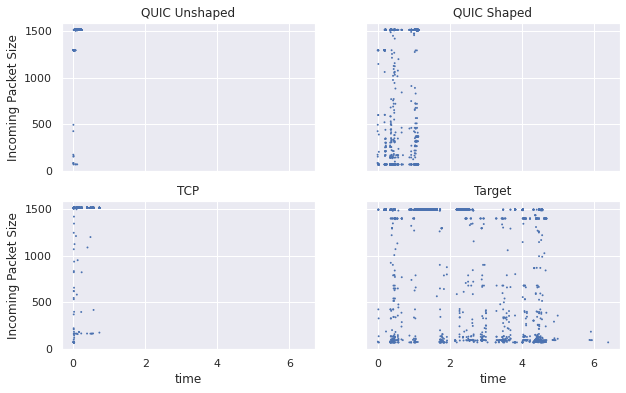

In [36]:
def plot_traffic(trace, direction: str="in", ax=None):
    trace = trace.copy()
    
    if ax is None:
        fig, ax = plt.subplots();
    
    if direction == "in":
        trace = trace[trace["size"] < 0].copy()
        trace["size"] = trace["size"].abs()
    sns.scatterplot(x=trace["time"], y=trace["size"], marker='.', ax=ax, edgecolor="none", s=15)
    
    return ax


def plot_traffic_with_baselines(mapping, *, direction: str="in"):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,6))
    
    for title, ax in zip(mapping.keys(), axes.ravel()):
        plot_traffic(mapping[title], direction=direction, ax=ax)
        ax.set_title(title)
        
        if direction == "in":
            ax.set_ylabel("Incoming Packet Size")
            
    return fig
        
    
plot_traffic_with_baselines({
    "QUIC Unshaped": UNSHAPED,
    "QUIC Shaped": SHAPED,
    "TCP": TCP_BASELINE,
    "Target": BASELINE,
}).savefig("smoothed-rx-traffic.png", dpi=150, bbox_inches="tight")

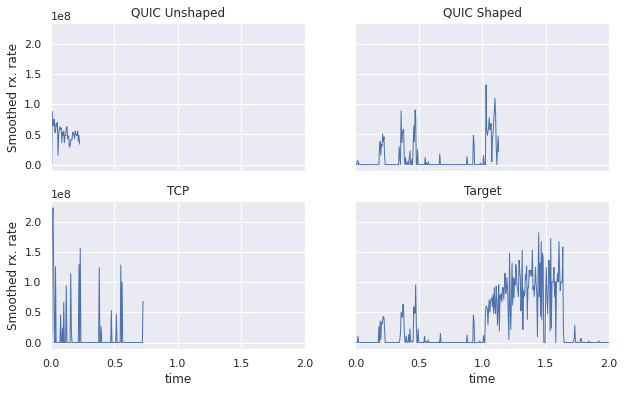

In [37]:
def plot_transmission_rate(trace, direction: str="in", ax=None):
    trace = trace.copy()
    
    if ax is None:
        fig, ax = plt.subplots();
    
    if direction == "in":
        trace = trace[trace["size"] < 0].copy()
        trace["size"] = trace["size"].abs()
        
    if 0 not in trace["time"]:
        trace = (trace.append([{"time": 0, "size": 0}])
                 .sort_values(by="time"))
        
    trace["time"] = pd.to_datetime(trace["time"], unit="s")
    
    # For 10ms windows we multiply the amount of data transfered by 100 to 
    # get the number of bytes that would be transferred in 1s for that rate
    # over 10ms. Multiply by 8 to get bits
    resample_ms = 5
    trace = (trace.resample(f"{resample_ms}ms", on="time").sum()
             .mul(8 * 1000 / resample_ms)
             .reset_index())
    
    sns.lineplot(x=trace["time"].astype(int) / 1e9, y=trace["size"], ax=ax, markers=False, linewidth=1)
    
    return ax


def plot_rate_with_baselines(mapping, *, direction: str="in"):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6))
    
    for title, ax in zip(mapping.keys(), axes.ravel()):
        plot_transmission_rate(mapping[title], direction=direction, ax=ax)
        ax.set_title(title)
        
        ax.set_xlim(0, 2)
        ax.set_ylabel("Smoothed rx. rate")
        
    return fig
        

    
plot_rate_with_baselines({
    "QUIC Unshaped": UNSHAPED,
    "QUIC Shaped": SHAPED,
    "TCP": TCP_BASELINE,
    "Target": BASELINE,
}).savefig("smoothed-rx-rate.png", dpi=150, bbox_inches="tight")

In [ ]:
data = data[data["length"] < 0]
baseline = baseline[baseline["length"] < 0]

In [ ]:
RATE = 0.001
binned = baseline.copy()
bins = np.arange(0, np.ceil(binned["time"].max()), RATE)
binned["bins"] =  pd.cut(binned["time"], bins=bins, right=False, labels=bins[:-1])
binned = binned.groupby("bins")["length"].sum()
binned = binned[binned != 0].reset_index()
binned

In [ ]:
mdframes = pd.read_csv("../../data/shaped-no-pad-mdframe.csv", header=0, usecols=[0, 2, 4], names=["time", "port", "md"]).sort_values(by="time")
mdframes = mdframes[mdframes["port"] == 38404]
mdframes = mdframes.drop_duplicates(subset="md")

mdframes["time_md"] = mdframes["time"] - mdframes.iloc[0, 0]
mdframes["md"] *= -1
mdframes["md"] = mdframes["md"].diff()
mdframes

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,10))

sns.scatterplot(x=mdframes["time_md"], y=mdframes["md"], marker='.', ax=axes[0], edgecolor="none")
sns.scatterplot(x=binned["bins"], y=binned["length"], marker='.', ax=axes[1], edgecolor="none")

axes[0].set_xlim(0, 2)
axes[1].set_title("Baseline")
axes[0].set_title("Shaped")


# fig.savefig("vanilla-template-shared.pdf", dpi=300)

In [ ]:
fig, (axes, baseline_axes, binned_axes) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,10))

sns.scatterplot(x=data["time"], y=data["length"], marker='.', ax=axes, edgecolor="none", s=15)
sns.scatterplot(x=baseline["time"], y=baseline["length"], marker='.', ax=baseline_axes, edgecolor="none", s=15)
# sns.scatterplot(x=binned["bins"], y=binned["length"], marker='.', ax=binned_axes, edgecolor="none")

axes.set_xlim(0, 2)
axes.set_ylim(-2000, 10)

baseline_axes.set_title("Baseline")
axes.set_title("Shaped")


# fig.savefig("vanilla-template-shared.pdf", dpi=300)